In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
import random
import time
from statistics import mean
import scipy.stats as stats
from sensitivity import SensitivityAnalyzer
from scipy.stats import shapiro

## Part 2: Testing average waiting times

### Defining simpy processes

In [2]:
class Logger():
    """Keeps track of waiting times"""
    def __init__(self, env):
        self.env = env
        self.waiting_times = []

    def log_waiting_time(self, waiting_time):
        self.waiting_times.append(waiting_time)


def customer_generator(env, landa, mu, n_samples, logger, counter):
    """Generates customers"""
    for k in range(n_samples):
        c = customer(env, f'Customer {k}', mu, logger, counter)
        env.process(c)
        t = random.expovariate(landa) #Average inter_arrival_time
        yield env.timeout(t)

        
def customer(env, name, mu, logger, counter):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = random.expovariate(mu)
        yield env.timeout(serving_time)


Running simulation

In [3]:
ns = [1,2,4] #Stores the different number of servers for each simulation run. 
landa = 0.56
mu= 0.6
n_samples = 10**5 #Starting number of customers
p = landa/(1*mu)
lst = []


# print(f'Utilization p = {p}')
for n in ns:
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator(env, landa, mu, n_samples, time_logger, counter))
    env.run(until=proc)
    lst.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1


Plotting simulation results

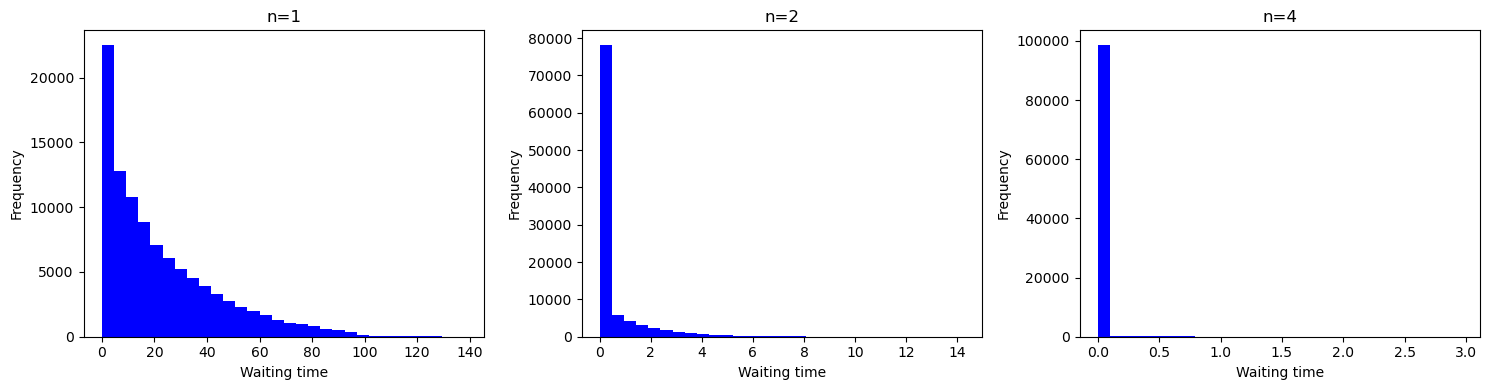

In [4]:
# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst):
    axs[indx].hist(t, density = False, bins = 30, color= 'b')
    axs[indx].set_title(f"n={ns[indx]}")
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Display the subplots
plt.show()

### Checking for normality of distribution of means by plotting

500


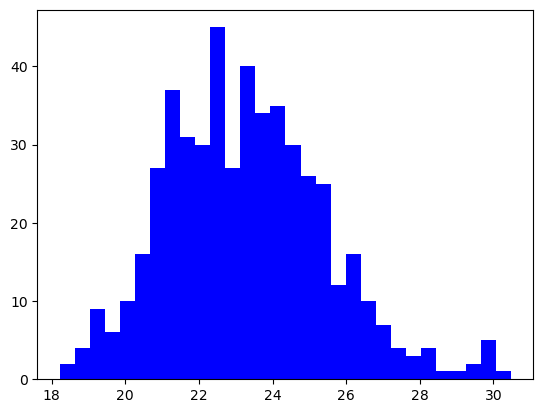

In [5]:
mean_list = []

for i in range(500):
    test_lst = []
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=1) #FOR ONLY 1 SERVER
    time_logger = Logger(env)
    proc = env.process(customer_generator(env, landa, mu, 100000, time_logger,counter))
    env.run(until=proc)
    test_lst.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1

    #print(server_1)
    mean_list.append(np.mean(test_lst))
    #print(mean_list)

plt.hist(mean_list, bins = 30, color= 'b')
print(len(mean_list))

### Testing for normality with shapiro test

In [6]:
stat, p_value = shapiro(mean_list)
print(f'Statistic: {stat}, p-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

Statistic: 0.9839778542518616, p-value: 2.5689747417345643e-05
Sample does not look Gaussian (reject H0)


## Part 3: Priority queues

### Non pre-emptive Queuing behaviour

In [7]:
def customer_generator_pr(env, landa, mu, n_samples, logger, priorities):
    """Generates customers with different priority levels for queue"""
    for k in range(n_samples):
        prio = np.random.choice(priorities)
        c = customer_pr(env, f'Customer {k}', mu, logger, prio)
        env.process(c)
        t = random.expovariate(landa) #Average inter_arrival_time
        yield env.timeout(t)

        
def customer_pr(env, name, mu, logger, prio):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
    with counter.request(priority=prio) as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = random.expovariate(mu)
        yield env.timeout(serving_time)

#### Arrival times when all queues are non-preemptive

Priority categories: [1, 2, 3]
Utilization p = 0.9666666666666667


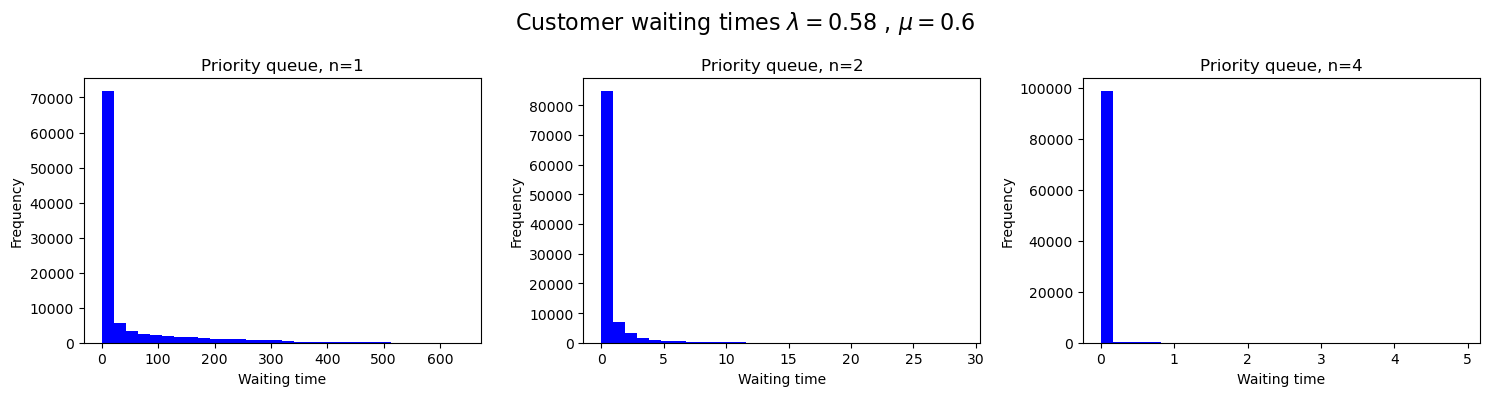

In [8]:
ns = [1,2,4] #Stores the different number of servers for each simulation run. 
landa = 0.58
mu= 0.6
n_samples = 10**5 #Starting number of customers
p = landa/(1*mu)
lst = []
priorities = [n for n in range(1,4)]
print(f"Priority categories: {priorities}")
print(f'Utilization p = {p}')
for n in ns:
    env = simpy.Environment()
    counter = simpy.PriorityResource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator_pr(env, landa, mu, n_samples, time_logger, priorities))
    env.run(until=proc)
    lst.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1

# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
titles = ['Priority queue, n=1', 'Priority queue, n=2', 'Priority queue, n=4']

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst):
    axs[indx].hist(t, density = False, bins = 30, color= 'b')
    axs[indx].set_title(titles[indx])
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adding a master title
fig.suptitle('Priority Queues, non-preemptive', fontsize=16)
fig.suptitle(f'Customer waiting times $\lambda={landa}$ , $\mu ={mu}$', fontsize=16)
    
# Adjusting layout
plt.tight_layout()
plt.show()

#### Arrival times when only n=1 is priority queue

Priority categories: [1, 2, 3]
Utilization p = 0.9666666666666667
Priority
Non-priority
Non-priority


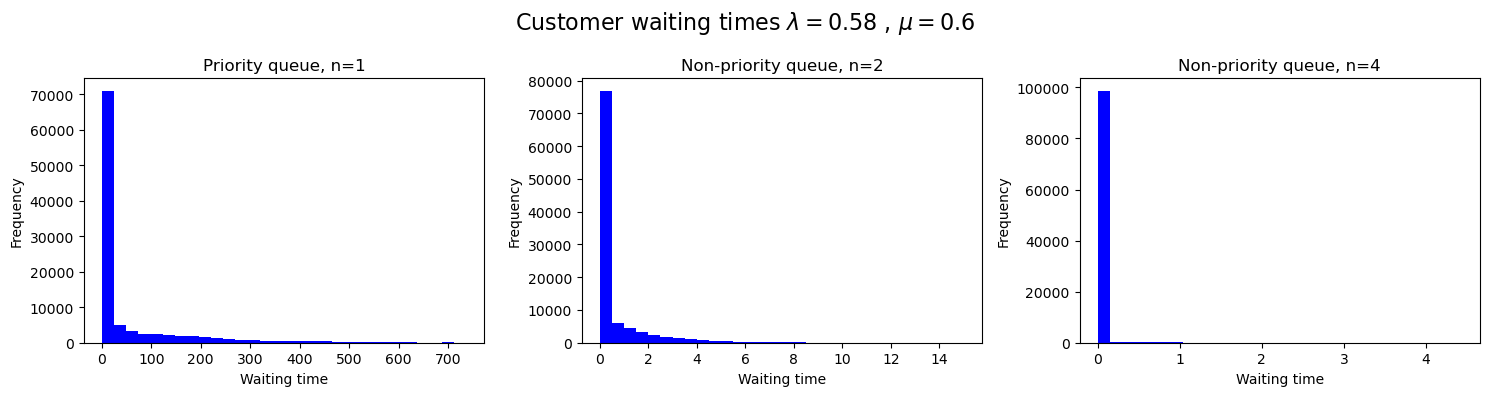

In [9]:
ns = [1,2,4] #Stores the different number of servers for each simulation run. 
landa = 0.58
mu= 0.6
n_samples = 10**5 #Starting number of customers
p = landa/(1*mu)
lst = []
priorities = [n for n in range(1,4)]
print(f"Priority categories: {priorities}")
print(f'Utilization p = {p}')

# Running simulation with n=1 being a priority queue and n > 1 being non-priority Queues
for n in ns:
    env = simpy.Environment()
    time_logger = Logger(env)
    if n == 1 :
        print('Priority')
        counter = simpy.PriorityResource(env, capacity=n)
        proc = env.process(customer_generator_pr(env, landa, mu, n_samples, time_logger,priorities))
    if n > 1:
        print('Non-priority')
        counter = simpy.Resource(env, capacity=n)
        proc = env.process(customer_generator(env, landa, mu, n_samples, time_logger, counter))
    env.run(until=proc)
    lst.append(time_logger.waiting_times) 

# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

titles = ['Priority queue, n=1', 'Non-priority queue, n=2', 'Non-priority queue, n=4']

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst):
    axs[indx].hist(t, density = False, bins = 30, color= 'b')
    axs[indx].set_title(titles[indx])
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adding a master title
fig.suptitle(f'Customer waiting times $\lambda={landa}$ , $\mu ={mu}$', fontsize=16)
    
# Adjusting layout
plt.tight_layout()
plt.show()

### Hypothesis-testing different queues

Generating means of means

In [10]:
def multiple_n_runs(landa, mu, ns, n_samples, priority_type='normal'):
    '''Runs queue simulation'''
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    time_logs = []
    env = simpy.Environment()
    
    #Defining queue types
    queues = {'normal': simpy.Resource(env, capacity=ns), 'priority': simpy.PriorityResource(env, capacity=ns)}
    
    if priority_type not in queues:
        raise ValueError(f"Priority type not availabla, use from following: {[x for x in queues]}")
        
    #Creating Queue
    counter = queues[priority_type]  
    time_logger = Logger(env)
    

    proc = env.process(customer_generator(env, landa, mu, n_samples, time_logger, counter))
    env.run(until=proc)
    time_logs.append(time_logger)  #Stores the waiting times for each simulation which involves a different numbers of servers given in the ns list
    
    #Returns waiting times
    return time_logger.waiting_times


In [11]:
def samples_generator(landa, mu, k, max_deviation, n, n_simulations, priority_type= 'normal'): # d1 = variance for waiting time mean per simulation, d2 = variance for total sample set, n = #servers
    '''Runs simulations until means distribution has deviation below given threshold'''
    means_lst = []
    deviation_lst = []
    
    # initialize sample set
    for _ in range(n_simulations): 
        times = multiple_n_runs(landa, mu, n, k, priority_type)
        means_lst.append(np.mean(times))
    
    # calculate first variance
    variance = np.var(means_lst)
    deviation = np.sqrt(variance)/np.sqrt(n_simulations)
    deviation_lst.append(deviation)
    
    # Verify if sample size is sufficient
    # We run simulation until variance < d
    while deviation_lst[-1] > max_deviation:
        
        n_simulations += 25
        means_lst = []
        
        for _ in range(n_simulations): 
            times = multiple_n_runs(landa, mu, n, k, priority_type)
            means_lst.append(np.mean(times))
    
        variance = np.var(means_lst)
        deviation = np.sqrt(variance)/np.sqrt(n_simulations)
        deviation_lst.append(deviation)
        
    return means_lst

In [12]:
def pretty_print(hypotheses):
    '''Prints nicely hypothesis results'''
    for k, hypothesis in enumerate(hypotheses):
        print(f"Hypothesis {k+1}")
        for values in hypothesis:
            mean, std, landa = values
            print(f"Mean p: {mean}, std:{std}, landa:{landa}")
        print('\n')

Executing tests between M/M/1 priority queue and M/M/1 FIFO queue


In [13]:
start_time = time.time()

# Non-parametric tests as normal distribution is not ensured
# Define different system loads rho = landa/c*mu
landa_variations = [1-10**(-3), 2-10**(-3), 2+10**(-3)]
mu = 1
iterations = 100
var = 1
p = 0.05
s_len = 100

all_p_vals = []
# Initalizing statistics list for each hypothesis
hypo1 = []
hypo2 = []
hypo3 = []
# generate simulation for different system loads 
for i in range(len(landa_variations)):
    landa = landa_variations[i]
  
    p_vals_Hypo1 = []
    p_vals_Hypo2 = []
    p_vals_Hypo3 = []
    
    # execute test 100 times for statistical relevance
    for iterations in range(100):
        # Generating distributions of means for both queue types
        #Non-priority Queues
        serv1_nonpr_nonparametric = samples_generator(landa, mu, iterations, var, 1, s_len)
        serv2_nonpr_nonparametric = samples_generator(landa, mu, iterations, var, 2, s_len)
        
        # Single server priority
        serv1_pr_nonparametric = samples_generator(landa, mu, iterations, var, 1, s_len, 'priority')
        serv2_pr_nonparametric = samples_generator(landa, mu, iterations, var, 2, s_len, 'priority')
        
        # execute
        Hypo_1_nonparametric = stats.mannwhitneyu(serv1_pr_nonparametric,serv1_nonpr_nonparametric)
        Hypo_2_nonparametric = stats.mannwhitneyu(serv1_pr_nonparametric,serv2_nonpr_nonparametric)
        Hypo_3_nonparametric = stats.mannwhitneyu(serv2_pr_nonparametric,serv1_nonpr_nonparametric)
    
        # Storing p value for this iteration
        p_vals_Hypo1.append(Hypo_1_nonparametric[1])
        p_vals_Hypo2.append(Hypo_2_nonparametric[1])
        p_vals_Hypo3.append(Hypo_3_nonparametric[1])
        
    #Storing mean and deviation for p-value distributions for each lambda iteration
#     hypo1.append((mean(p_vals_Hypo1), np.nanstd(p_vals_Hypo1), landa))
#     hypo2.append((mean(p_vals_Hypo2), np.nanstd(p_vals_Hypo2), landa))
#     hypo3.append((mean(p_vals_Hypo1), np.nanstd(p_vals_Hypo3), landa))
    
    hypo1.append((np.nanmean(p_vals_Hypo1), np.nanstd(p_vals_Hypo1), landa))
    hypo2.append((np.nanmean(p_vals_Hypo2), np.nanstd(p_vals_Hypo2), landa))
    hypo3.append((np.nanmean(p_vals_Hypo3), np.nanstd(p_vals_Hypo3), landa))
    

hypotheses = [hypo1, hypo2, hypo3]

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

pretty_print(hypotheses)

/Users/alex_1/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alex_1/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Time taken: 37.09997320175171 seconds
Hypothesis 1
Mean p: 0.5120637499352293, std:0.27657243080008315, landa:0.999
Mean p: 0.4772814568315598, std:0.310660521335744, landa:1.999
Mean p: 0.5070975260678804, std:0.288838458204758, landa:2.001


Hypothesis 2
Mean p: 0.0101011064613078, std:0.09999488862030222, landa:0.999
Mean p: 0.010101347977457225, std:0.09999486427301447, landa:1.999
Mean p: 0.010125824744671033, std:0.09999268440091928, landa:2.001


Hypothesis 3
Mean p: 0.010101010659559774, std:0.09999489829319085, landa:0.999
Mean p: 0.01010106219527833, std:0.09999489308798884, landa:1.999
Mean p: 0.010101242659134148, std:0.09999487487072038, landa:2.001




### Sensitivity Analysis


Sensitivity analysis between M/M/1 priority queue and M/M/1 FIFO queue

100%|██████████| 25/25 [00:03<00:00,  8.05it/s]


<Figure size 1920x1440 with 0 Axes>

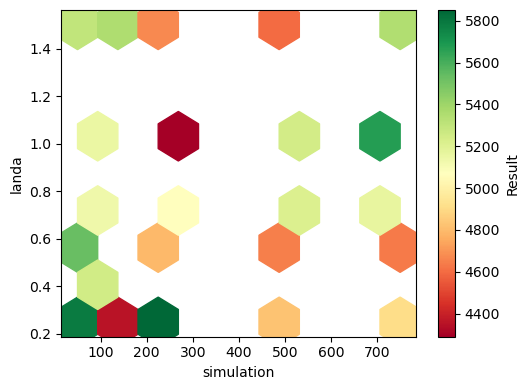

In [14]:
# generate model for data required for sensitivity analysis
def model2(simulation, landa):
    
    mu = 1
    custom = 100
    var = 1
    
    # execute simulations for varying numbers of servers, fixed number of customers per iteration
    serv1_nonpr_nonparametric = samples_generator(landa, mu, iterations, var, 1, s_len, 'normal')
    serv1_pr_nonparametric = samples_generator(landa, mu, iterations, var, 1, s_len, 'priority')
    
    # execute test to obtain p-values
    Hypo_1_nonparametric = stats.mannwhitneyu(serv1_pr_nonparametric,serv1_nonpr_nonparametric)
    
    p_vals = [Hypo_1_nonparametric[0]]#, Hypo_2, Hypo_2]
    return p_vals

# define variation across parameters for sensitivity analysis [10, 25, 50, 75, 100]
sensitivity_dict = {
    'simulation': [50, 100, 250, 500, 750], 
    'landa': [0.25, 0.5, 0.75, 1-10**(-3), 1.5]
}

# execute sensitivity analysis
sa = SensitivityAnalyzer(sensitivity_dict, model2)

# plot results
plt.figure(dpi = 300)
plot = sa.plot()
plt.show()
plt.close()


Alternative Sensitivity analysis

## Part 4: Experimenting with different service rate distributions

### M/D/1 and M/D/n queues 

In [15]:
#Adjusting customer method to make customers wait for a constant rate of time (deterministic serving time)
def customer_md(env, logger):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
#     print('yes')
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = 1.63 #Setting a constant serving time (This is a cherry picked time from one of the times that would usually be generated by the expovariate function)
        yield env.timeout(serving_time)

#Adjusting customer method to account for customer_md method
def customer_generator_md(env, landa, mu, n_samples, logger):
    """Generates customers"""
    for k in range(n_samples):
        c = customer_md(env, logger)
        env.process(c)
        t = random.expovariate(landa) #inter_arrival_time is still drawn from exponential distribution
        yield env.timeout(t)

In [16]:
ns = [1,2,4] #Stores the different number of servers for each simulation run. 
landa = 0.56
mu= 0.6
n_samples = 10**5 #Starting number of customers
p = landa/(1*mu)
lst_md = []

for n in ns:
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator_md(env, landa, mu, n_samples, time_logger)) #USING THE SAME PARAMETERS DEFINED ABOVE
    env.run(until=proc)
    lst_md.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1


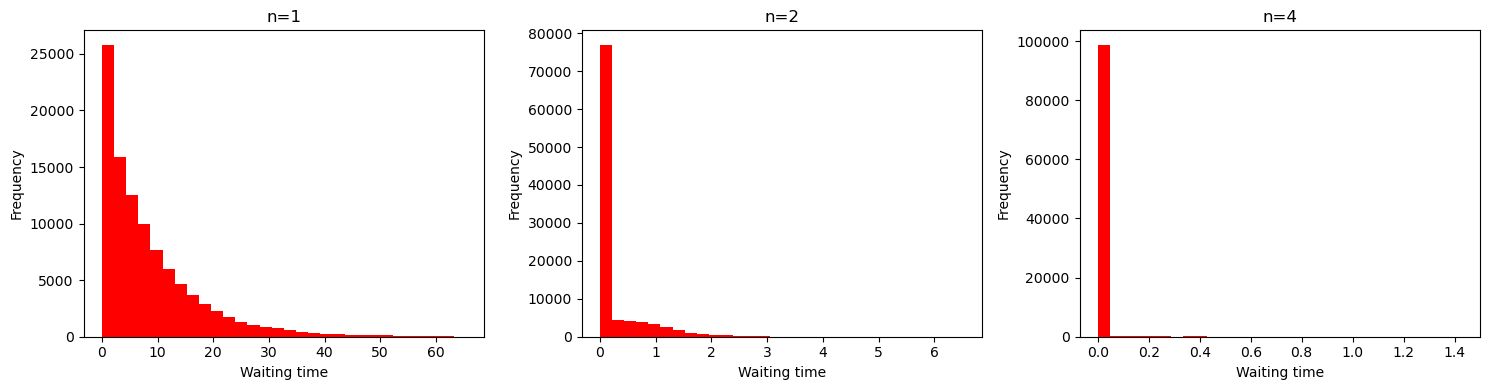

In [17]:
# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst_md):
    axs[indx].hist(t, density = False, bins = 30, color= 'r')
    axs[indx].set_title(f"n={ns[indx]}")
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Display the subplots
plt.show()

#### Plots are now deterministic. High value for serving time was chosen

### Long tail distribution (Hyperexponential distribution)

In [18]:
#Define a method that generates random numbers from a hyperexponential distribution
def generate_hyperexp_num(probabilities,mus): 
    '''Generates service times using hyperexponential distribution '''
    #probabilities = the probabilities of each mu occuring 
    #mus = different average service times
    
    #Check probabilities sum to 1
    if(sum(probabilities) != 1):
        raise ValueError("Probabilities must sum to 1")
    
    random_mu = random.choices(mus, weights=probabilities, k = 1) [0] #Select a random mu weighted by their probabilities. [0] ensures that the number is not returned in a list
    
    random_time = random.expovariate(1/random_mu) #Generate a random time based on a random mu -->
    return random_time

# Testing the function
generate_hyperexp_num([0.75,0.25],[1,5])

0.5701839446929684

#### Defining methods for hyperexponential queue simulation

In [19]:

#Specify probabilities and mus (positions are matched to ensure probability in ps corresponds to mu in mus)
ps = [0.75,0.25]
mus = [1,5] 

#Adjusting customer method to make customers wait for a long tail rate of time (serving time drawn from hyperexponential distribution)

def customer_long_tail(env,logger):
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = generate_hyperexp_num(ps,mus) #Serving time according to hyperexponential distribution
        yield env.timeout(serving_time)

#Adjusting customer method to account for customer_md method
def customer_generator_long_tail(env, landa, n_samples, logger):
    """Generates customers"""
    for k in range(n_samples):
        c = customer_long_tail(env, logger)
        env.process(c)
        t = random.expovariate(landa) #inter_arrival_time is still drawn from exponential distribution
        yield env.timeout(t)

#### Running simulation for different server numbers $n$

In [20]:
lst_long_tail = []

for n in ns:
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=n)
    time_logger = Logger(env)
    proc = env.process(customer_generator_long_tail(env, landa,n_samples, time_logger)) #USING THE SAME PARAMETERS DEFINED ABOVE
    env.run(until=proc)
    lst_long_tail.append(time_logger.waiting_times) #A list of waiting times for each customer in each simulation 1

#### Plotting results

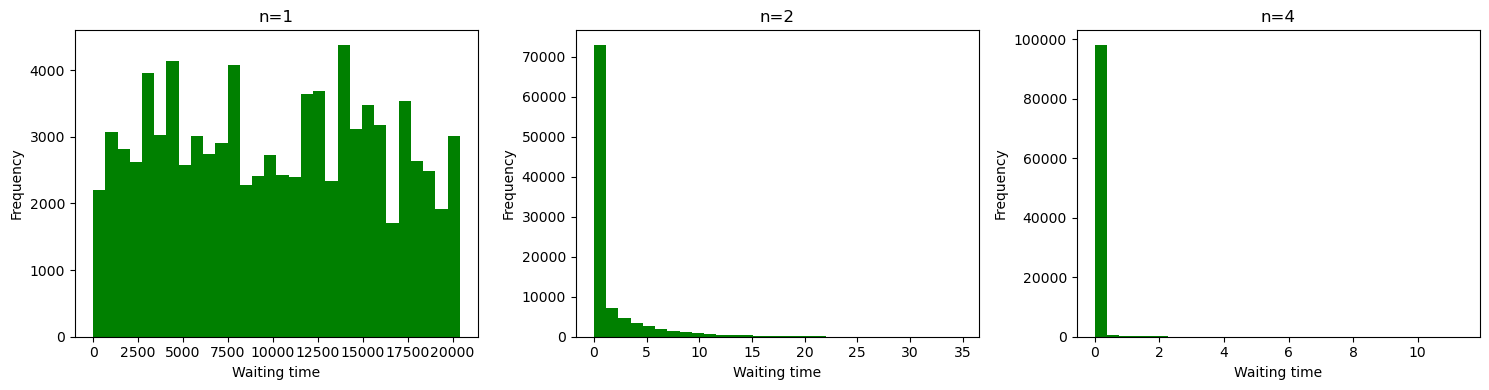

In [21]:
# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plotting each histogram in a separate subplot
for indx, t in enumerate(lst_long_tail):
    axs[indx].hist(t, density = False, bins = 30, color= 'g')
    axs[indx].set_title(f"n={ns[indx]}")
    axs[indx].set_xlabel('Waiting time')
    axs[indx].set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Display the subplots
plt.show()

## Hypothesis testing with M/D/1 Queue and M/M/1 Queue

In [30]:
#H0: E(waiting times)_m/d/1 = E(waiting times)_m/m/1

#Defining methods for M/D/1 queue
def customer_md(env, logger,counter,serving_time): #Deterministic customer service times. Pass in the deterministic service time as a parameter
    "Simulates queue behaviour and logs waiting times"
    arrival = env.now
#     print('yes')
    with counter.request() as req:
        yield req
        #Saving the time we waited 
        served = env.now
        waiting_time  = served - arrival
#         print(waiting_time)
        logger.log_waiting_time(waiting_time)
        #Getting served for X amount of time
        serving_time = serving_time #Setting a constant serving time (This is a cherry picked time from one of the times that would usually be generated by the expovariate function)
        yield env.timeout(serving_time)

# Adjusting customer method to account for customer_md method
def customer_generator_md(env, landa, n_samples, logger,counter,service_time):
    """Generates customers"""
    for k in range(n_samples):
        c = customer_md(env, logger,counter,service_time)
        env.process(c)
        t = random.expovariate(landa) #inter_arrival_time is still drawn from exponential distribution
        yield env.timeout(t)


def multiple_n_runs_md(landa, ns, n_samples,service_time): 
    '''Function that runs simulation for different server number n'''
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    time_logs = []

    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=ns)
    time_logger = Logger(env)
    proc = env.process(customer_generator_md(env, landa, n_samples, time_logger, counter, service_time))
    env.run(until=proc)
    time_logs.append(time_logger)  #Stores the waiting times for each simulation which involves a different numbers of servers given in the ns list
    return [logger.waiting_times for logger in time_logs]


def samples_generator_md(landa, ns, n_samples,d, service_time,s_len): # d1 = variance for waiting time mean per simulation, d2 = variance for total sample set, n = #servers
    '''Runs simulations until means distribution has deviation below given threshold. Returns distribution of means'''
    m_list = []
    d_lst = []
    
    # initialize sample set
    for s in range(s_len): 
        times = multiple_n_runs_md(landa, ns, n_samples,service_time)         
        m_list.append(mean(times[0]))
    
    # calculate first variance
    variance = np.var(m_list)
    deviation = np.sqrt(variance)/np.sqrt(s_len)
    d_lst.append(deviation)
    
    # verify if sample size is sufficient
    while d_lst[-1] > d:
        
        s_len = s_len + 25
        m_list = []
        for s in range(s_len): 
            times = multiple_n_runs_md(landa, ns, n_samples,service_time)
            m_list.append(mean(times[0]))
    
        variance = np.var(m_list)
        deviation = np.sqrt(variance)/np.sqrt(s_len)
        d_lst.append(deviation)

    return m_list

In [45]:
# Non-parametric tests as normal distribution is not ensured
# Define different system loads rho = landa/c*mu

#landa_variations = [1-10**(-3), 2-10**(-3), 2+10**(-3)]
landa = 1-10**(-3)
deterministic_service_times = np.arange(0.5,2,0.1)
#deterministic_service_times = [1]
mu = 1
iterations = 100
var = 1
p = 0.05
s_len = 100

all_p_vals = []

# generate simulation for different system loads 
for i in range(len(deterministic_service_times)):
    service_time = deterministic_service_times[i]
    p_vals_Hypo1 = []
    
    # execute test 100 times for statistical relevance
    for iters in range(100):
        # generate data
        m_m_1_data = samples_generator(landa, mu, iterations, var, 1, s_len, 'normal') #Fix servers to 1
        
#         m_m_1_data = s_gen(landa, mu, iterations, var, 1, s_len) #Fix servers to 1
        m_d_1_data = samples_generator_md(landa, 1,iterations, var, service_time, s_len) #Fix servers to 1
        # execute test
        Hypo_1 = stats.mannwhitneyu(m_m_1_data, m_d_1_data) #Calculate p values for the 2 sets of data
        # store p values
        p_vals_Hypo1.append(Hypo_1[1])
 
    # take the mean and standard deviation of the p values
    mean_p_vals1 = mean(p_vals_Hypo1)
    dev1 = np.std(p_vals_Hypo1)

    
    all_p_vals = all_p_vals + [service_time, mean_p_vals1, dev1]
    #print(f"Service time = {service_time} \n Mean p value = {mean_p_vals1} \n Standard deviation = {dev1} \n ")

# print result of all simulations


In [46]:
print(all_p_vals)

[0.5, 2.5684185680405957e-34, 2.4055593702798448e-36, 0.6, 2.8308891498795182e-34, 6.217008253655425e-35, 0.7, 3.748543766922232e-33, 1.507016410071953e-32, 0.7999999999999999, 1.7025009050635116e-26, 9.960733229346386e-26, 0.8999999999999999, 3.322148764299507e-13, 1.979851899666244e-12, 0.9999999999999999, 0.03060099089841003, 0.08428561457951732, 1.0999999999999999, 0.05400105532752452, 0.10553654923809042, 1.1999999999999997, 2.396739840274588e-08, 1.9605372535868526e-07, 1.2999999999999998, 3.998374542847162e-15, 3.9775268354326394e-14, 1.4, 3.9203194163522545e-25, 1.8065479634612983e-24, 1.4999999999999998, 6.907037809884543e-30, 3.95353534272425e-29, 1.5999999999999996, 1.0231282840825724e-31, 4.833550434628347e-31, 1.6999999999999997, 3.90041751904304e-33, 7.86994565025702e-33, 1.7999999999999998, 1.0664957160127917e-33, 2.2659129819073602e-33, 1.8999999999999997, 4.730583804728363e-34, 5.728049341936237e-34]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


<Figure size 1920x1440 with 0 Axes>

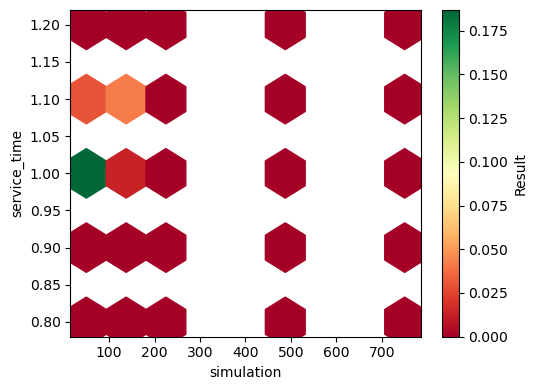

In [47]:
# generate model for data required for sensitivity analysis
def model_md(simulation, service_time):
    
    mu = 1
    custom = 100
    var = 1
    landa = 1-10**(-3)
    
    # execute simulations for varying numbers of servers, fixed number of customers per iteration
    m_m_1_data = samples_generator(landa, mu, custom, var, 1, simulation, 'normal') #Fix servers to 1
    m_d_1_data = samples_generator_md(landa, 1,custom, var, service_time, simulation) #Fix servers to 1
    
    # execute test to obtain p-values
    Hypo_1 = stats.mannwhitneyu(m_m_1_data, m_d_1_data)
    
    p_vals = [Hypo_1[1]]#, Hypo_2, Hypo_2]
    return p_vals

# define variation across parameters for sensitivity analysis [10, 25, 50, 75, 100]
sensitivity_dict = {
    'simulation': [50, 100, 250, 500, 750], 
    'service_time': [0.8, 0.9, 1, 1.1, 1.2]
}

# execute sensitivity analysis
sa = SensitivityAnalyzer(sensitivity_dict, model_md)

# plot results
plt.figure(dpi = 300)
plot = sa.plot()
plt.show()
plt.close()